In [1]:
import numpy as np
import pandas as pd
import wandb

# Set your API key directly
wandb.login(key='abe7c0b65234f4097e19c8fb2565b81a466c3679')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [2]:
reviews = pd.read_json('/kaggle/input/imdb-spoiler-dataset/IMDB_reviews.json', lines=True)

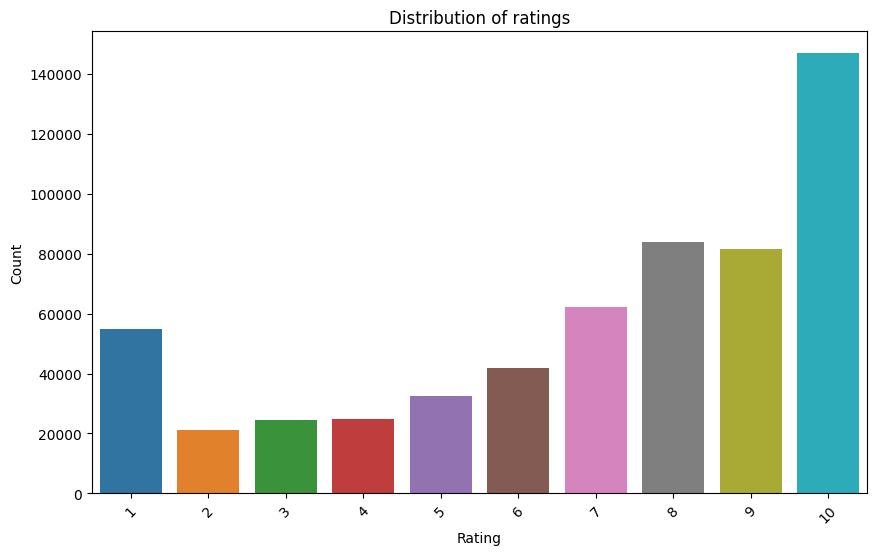

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=reviews)

plt.title('Distribution of ratings') 
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.show()

In [4]:
bad_reviews = reviews[reviews['rating'] <= 2]

In [5]:
bad_reviews

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
21,24 May 2005,tt0111161,ur2074071,True,It bugs me that this movie is rated so high- n...,1,Mediocre people reward mediocre cinema.
40,24 September 2009,tt0111161,ur18477924,True,Shawshank is on TNT approximately five million...,1,Terrifyingly Overrated
45,18 July 2005,tt0111161,ur6229069,True,The basic story for this dreadful movie is And...,1,Am i missing something??
49,8 August 2006,tt0111161,ur11098798,True,"Over-long, boring, tedious, over-acted and ver...",1,More like The SHAM-shank Redemption - SPOILER
121,14 February 2003,tt0111161,ur2155387,True,"People wonder why I hate this movie so much, a...",1,Totally Unoriginal *spoilers*
...,...,...,...,...,...,...,...
573855,17 April 1999,tt0139239,ur0161832,False,This movie is a total hack. The opening scene...,2,Edited and acted well; but I can't believe thi...
573859,4 January 2002,tt0139239,ur0224914,False,"Good acting here, especially from Sarah Polley...",2,"Sarah rulez, but can't save the movie"
573863,17 January 2001,tt0139239,ur0897109,False,That's a completely superfluous movie - there'...,2,"bad, full of clichés, completely uninspired"
573871,26 April 2000,tt0139239,ur0651295,False,This cinematic experience was quite horrid. T...,1,Worst Film Ever


In [6]:
bad_reviews.iloc[0]['review_text']

'It bugs me that this movie is rated so high- not because it\'s a "bad" movie, but because it\'s a mediocre one. Apparently, mediocre people reward mediocre cinema. This movie tanked big-time when it was initially released, and with good reason. It wasn\'t until pseudo-intellectuals across the country started hyping it as defacto "favorite movie" for Lowbrows world-wide that it started dominating the IMDb "best movie" list. In reality, "Shawshank" is like a sewage pump for every idiotic Prison Movie cliché ever made. Every guard is a monster. The warden is religious, therefore Evil. Not a single prisoner is actually guilty, or if they are, they\'re so obviously redeemed that we\'re supposed to feel sorry for their unfair imprisonment. Murderers and sex offenders sit around in beatific awe as Opera plays over the loudspeakers. Right. The whole movie is so fake, so smarmy, and so condescending that it\'s no wonder that so many Americans, (with their odd addiction to fake, smarmy, condesc

In [7]:
import re

def cleaning(s):
    s = str(s)
    s = re.sub('\s\W',' ',s)
    s = re.sub('\W,\s',' ',s)
    s = re.sub("\d+", "", s)
    s = re.sub('\s+',' ',s)
    s = re.sub('[!@#$_]', '', s)
    s = s.replace("co","")
    s = s.replace("https","")
    s = s.replace("[\w*"," ")
    return s

In [8]:
text_data = open('Reviews.txt', 'w')
for idx, item in bad_reviews.iterrows():
    r = cleaning(item['review_text'])
    text_data.write(r)
text_data.close()

In [9]:
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import Trainer, TrainingArguments

2024-05-17 23:29:55.776985: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 23:29:55.777086: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 23:29:55.906989: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
def load_dataset(file_path, tokenizer, block_size = 128):
    dataset = TextDataset(
        tokenizer = tokenizer,
        file_path = file_path,
        block_size = block_size,
    )
    return dataset


def load_data_collator(tokenizer, mlm = False):
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, 
        mlm=mlm,
    )
    return data_collator


def train(train_file_path,model_name,
          output_dir,
          overwrite_output_dir,
          per_device_train_batch_size,
          num_train_epochs,
          save_steps):
    print("### LOAD TOKENIZER ###")
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    print("### LOAD DATASET ###")
    train_dataset = load_dataset(train_file_path, tokenizer)
    data_collator = load_data_collator(tokenizer)

    tokenizer.save_pretrained(output_dir)
    print("### LOAD PRE TRAINED ###")
    model = GPT2LMHeadModel.from_pretrained(model_name)

    model.save_pretrained(output_dir)
    
    training_args = TrainingArguments(
          output_dir=output_dir,
          overwrite_output_dir=overwrite_output_dir,
          per_device_train_batch_size=per_device_train_batch_size,
          num_train_epochs=num_train_epochs,
          save_strategy="no"
    )

    print("### START TRAINING ###")
    trainer = Trainer(
          model=model,
          args=training_args,
          data_collator=data_collator,
          train_dataset=train_dataset,
    )
      
    trainer.train()
    trainer.save_model()

In [11]:
# you need to set parameters 
train_file_path = "/kaggle/working/Reviews.txt"
model_name = 'gpt2'
output_dir = '/kaggle/working/result'
overwrite_output_dir = False
per_device_train_batch_size = 8
num_train_epochs = 1.0
save_steps = 500

In [12]:
# It takes about 30 minutes to train in colab.
train(
    train_file_path=train_file_path,
    model_name=model_name,
    output_dir=output_dir,
    overwrite_output_dir=overwrite_output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    num_train_epochs=num_train_epochs,
    save_steps=save_steps
)

### LOAD TOKENIZER ###


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

### LOAD DATASET ###


/opt/conda/lib/python3.10/site-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


### LOAD PRE TRAINED ###


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

### START TRAINING ###


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
wandb: Currently logged in as: oulkaddailyas (ilyas-17). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.6
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240517_233328-yb5ohc38
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run robust-aardvark-10
wandb: ⭐️ View project at https://wandb.ai/ilyas-17/huggingface
wandb: 🚀

Step,Training Loss
500,4.080500
1000,3.955500
1500,3.926800
2000,3.910700
2500,3.876100
3000,3.865300
3500,3.860700
4000,3.843500
4500,3.829700
5000,3.831700
